# Cleaning PV Power Data

Real world PV data is often messy. In this post I show some methods I've developed as part of my research to handle messy PV data.

### Introduction: good and bad PV data

When we think of [photovoltaic](https://en.wikipedia.org/wiki/Photovoltaics) (PV) system power data, we often think of something like this:

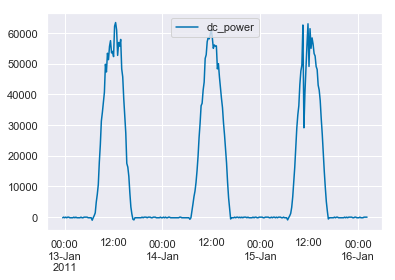

We expect to see a daily pulse, starting from zero watts just before sunrise and returning to zero watts just after sunset. It should have a peak somewhere around the middle of the day. Sometimes that pulse is "corrupted" by the effects of clouds, as seen in the first and third days above. In addition, we typically assume that the data is being measured at regular intervals, such as every minute or every five minutes. The data we see is an accurate reflection of what the system did at that time.

However, the reality is that many data sets deviate from these expectations in a number of ways. You might have:

- Missing data, both during the day and at night
- Changing or irregular measurement intervals
- Changes in local clock time (time shifts)

Data can be missing for many reasons. For example, a data acquisition system may go offline for a few hours and fail to collect data while the system is producing power. Alternatively, it is not uncommon for some data acquisition systems to simply stop collecting data when the sun goes down, and both issues might happen in the same data set. 

Similarly, there can be multiple causes of changing or irregular measurement intervals. On the one hand, you might have a data logger that was commissioned with a 5 minute aggregation period, which was later changed to be a 1 minute aggregation period.* On the other hand, you can have individual "skipped scans," in which single timestamps are missing or delayed.

Continuing the theme, the recorded time can appear to shift suddenly relative to the underlying physical processes for a number of reasons. A common one is mishandling of daylight saving's time shifts. However, it is also not uncommon for a datalogger to simply have it's internal clock changed for some reason.

__________________________________________________________________________________________________
\* Most data loggers provide built in functions for measuring at a high scan rate, like every 5 seconds, but then only storing rolled up statistics, such as 1 or 5 minute averages.

### Data cleaning: prepairing for analysis

Fundamentally, if a data set is too corrupted by the types of errors described above, it will not be possible to extract useful information from that data set. But for moderately corrupted data sets, we want to clean up these types of errors so that we can then analyze the data, such as to analyze degradation or look for loss factors. I am particularly interested in methods that automate this process. 

In this post, I am presenting recent work on fixing common PV data errors automatically with Python. All this is open-source under a [BSD 2-Clause License](https://github.com/slacgismo/solar-data-tools/blob/master/LICENSE). You can find the (most up to date) code here: https://github.com/slacgismo/solar-data-tools. We also have PyPI and Conda releases.

In this post, I'll show some example data sets to illustrate the difference between clean and messy data. The data we'll be using is provided free by NREL as the [PVDAQ service](https://developer.nrel.gov/docs/solar/pvdaq-v3/). You can get an [API key here](https://developer.nrel.gov/docs/api-key/). Also in the `solardatatools` package is a wrapper over the PVDAQ API, which we'll use in this post to get our data.

### Data example: (mostly) clean

Let's start by taking a look at a relatively "clean" data set.  We'll start by importing the functions we'll need from `solardatatools` (and `pandas`).

In [1]:
from solardatatools import get_pvdaq_data, standardize_time_axis, make_2d, plot_2d, fix_time_shifts
import pandas as pd

Next, we load our API key for PVDAQ

In [2]:
import os
home = os.path.expanduser('~')
with open(home + '/.api_keys/nrel.txt') as f:
    lines = f.readlines()
    api_key = lines[1].strip('\n')

Next, we make our API request for data at a site in the PVDAQ database. You can find a searchable map with site IDs [here](https://maps.nrel.gov/pvdaq/?aL=zNVfnk%255Bv%255D%3Dt&bL=clight&cE=0&lR=0&mC=40.21244%2C-91.625976&zL=4). I'm picking site `35` because I know it to be a good data set.

The PVDAQ API provides a number of ways to access the data, but my prefered approach (and the one that is implemented in my wrapper), is the _yearly CSV file API_. This returns a full year of high-resultion data for a site from a single request and is the fasted way to get a large amount of high-frequency data from the service. To get multiple years of data, multiple API requests must be generated. As shown below, the wrapper from `solardatatools` automates this process.

In [3]:
df1 = get_pvdaq_data(sysid=35, year=[2011, 2012, 2013], api_key=api_key, standardize=False)

The wrapper returns a `pandas` data frame. We can view the time-series power data as follows.

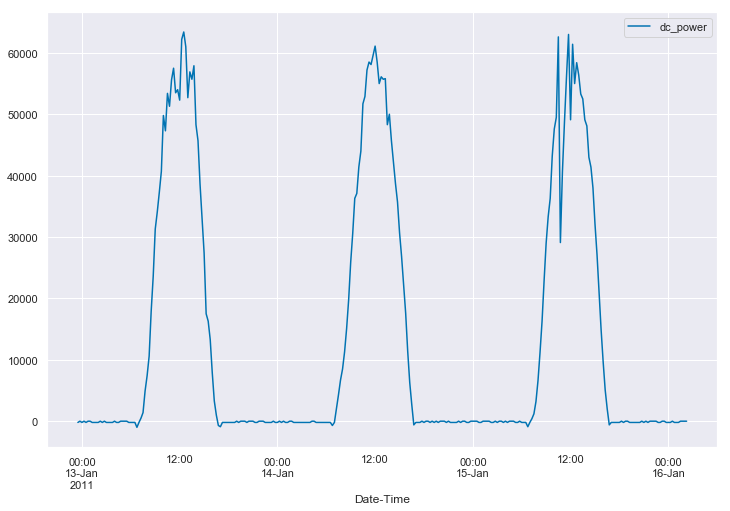

In [4]:
plt.figure(figsize=(12,8))
ax = plt.gca()
df1['Date-Time'] = pd.to_datetime(df1['Date-Time'])
df1.set_index('Date-Time', inplace=True)
df1.iloc[1150:1450].plot(y='dc_power', ax=ax);

And now we see where the image at the top of the post came from. But this is just a few days in January. How do we get a feel for the whole data set at once. Well, we could try just plotting the whole thing...

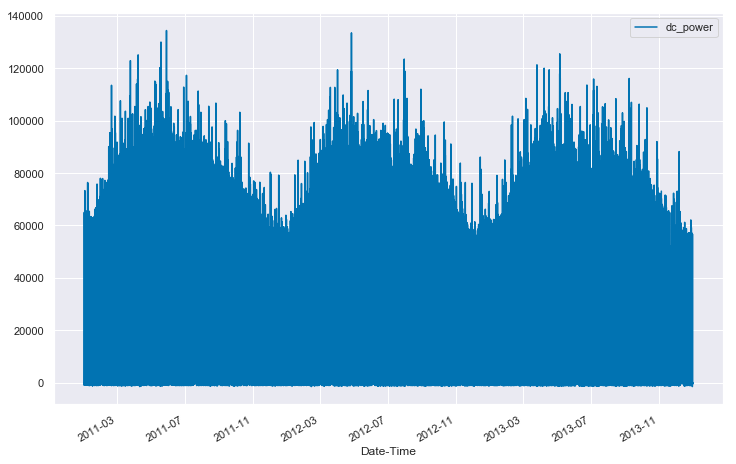

In [5]:
plt.figure(figsize=(12,8))
ax = plt.gca()
df1.plot(y='dc_power', ax=ax);

...but that's not overly helpful. We can see a little bit of the seasonal structure in the data, but we have no real sense of the quality of the data. 

For this reason, I prefer to look at the data in "2-D form". In other words, form a 2-D array (or matrix) where each column is 1 day of data from the data set. Then, we can view the entire data set at once as an image, where the pixel intensity is mapped to the power output.

How do we go about doing that? Well, if we know the number of samples collected in each day, then we can use numpy to reshape the 1-D array into the correct 2-D shape. So, let's start by taking a look at a few rows of data in the data frame.

In [6]:
df1.head()

,SiteID,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inv1_ac_power,inverter_airtemp,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
Date-Time,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,35,0.0,-200.0,284.0,-3.353332,-3.0,-200.0,18.0,NaN,NaN,0,25.0,-7.105555,0.0,0.0,53.513,315.270,0.483250
2011-01-01 00:15:00,35,0.0,-200.0,284.0,-3.381110,-4.0,-200.0,18.0,NaN,NaN,0,25.0,-6.944444,0.0,0.0,53.581,308.835,0.698724
2011-01-01 00:30:00,35,0.0,-300.0,284.0,-3.257777,-3.0,0.0,17.0,NaN,NaN,0,25.0,-6.344444,0.0,0.0,53.413,272.678,0.218156
2011-01-01 00:45:00,35,0.0,-300.0,284.0,-3.296666,-3.0,-200.0,17.0,NaN,NaN,0,24.0,-6.655555,0.0,0.0,52.406,55.913,0.159146
2011-01-01 01:00:00,35,0.0,-300.0,284.0,-3.426110,-3.0,-200.0,16.0,NaN,NaN,0,24.0,-7.405555,0.0,0.0,53.588,152.145,0.240508


We see that the data in our table is measured every 15 minutes. That means that there should be 

$$ \frac{24 \times 60}{15} = 96 $$ 

measurements in each day. So, let's give that a shot.

In [7]:
try:
    power_matrix = df1['dc_power'].values.reshape(96, -1, order='F') / 1000 # convert W to kW
except Exception as e:
    print('Something failed:', e)

Something failed: cannot reshape array of size 105088 into shape (96,newaxis)


Huh, that didn't work. Why not?

Well, the data frame that we got from PVDAQ has `105088` rows, and `96` does not go into that number evenly.

In [8]:
105088 / 96

1094.6666666666667

Hmmm... well we could try just removing some rows. If we remove `64` rows from the table, then we would have `105024` rows, which is a multiple of `96`.

In [9]:
power_matrix = df1['dc_power'].iloc[:105024].values.reshape(96, -1, order='F') / 1000 # convert W to kW

Well, that seemed to work. Let's try viewing the matrix we created.

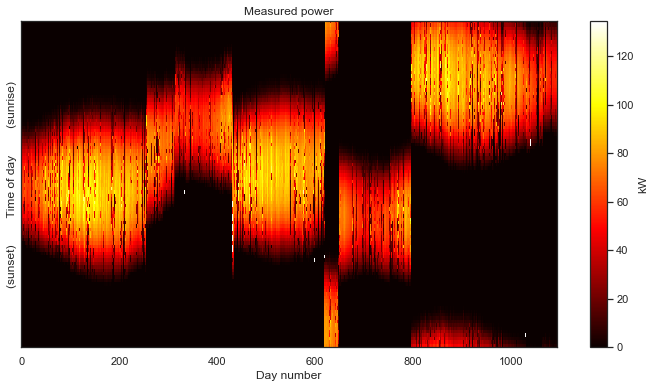

In [10]:
plot_2d(power_matrix);

Oh boy, we seem to have a problem. Things start out okay for the first `250` days or so, but then after that, we get some wild shifts in the alignment of the days. The issue here is gaps in the data. When we are missing timestamps, we no longer have exactly 96 rows for each day. The way to fix this is to _standardize the time axis_. This is a process of generating a correct time axis, with exactlty 96 measurements each day, and then aligning the available data to fit the newly generated time stamps as closely as possible.

The function `standardize_time_axis` from `solardatatools` performs this work for you, automatically detecting the correct frequency of data points, generating a new time axis, and filling in the data.

In addition, the function `make_2d` automatically detects the correct number of data points in each day and constructs the 2-D array. Note that while this data set has `96` measurements per day, a data set with 1-minute data would have `1440` measurements per day.

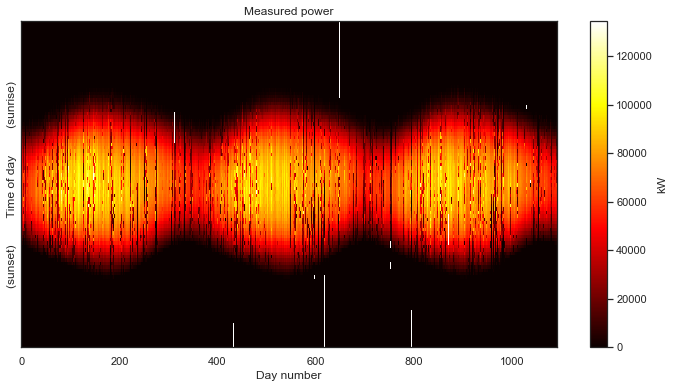

In [11]:
df1 = standardize_time_axis(df1)
power_matrix_raw1 = make_2d(df1, key='dc_power', zero_nighttime=False, interp_missing=False)
plot_2d(power_matrix_raw1);

And now, having correctly aligned the measurements, we finally get our first glimpse of the overall data set. The seasonal variation over the three years captured by the data is clearly visible. The white parts of the gaps in the data introduced by the standardization of the time axis. Now the caps in our data are clearly visible; we know exactly when they occur in the data set.

Despite these gaps, this is would still be considered a very clean data set. This is "good data." There aren't many gaps and we see a nice, clean daily pulse, than changes slowly from day-to-day, as the seasons change. If we wanted to, we could fill the missing data with zeros, and move on with our analysis.

But clean data isn't what this post is about. This post is about...

## Data example: messy

Let's take a look at another system in the PVDAQ database, shall we? This time, we'll use the flag `standardize=True` to automatically standardize the time axis after collecting the data from the server.

In [12]:
df = get_pvdaq_data(sysid=1200, year=[2011, 2012, 2013], api_key=api_key, standardize=True)

Okay, the time axis standardization is taken care of. Let's take a look at what we got.

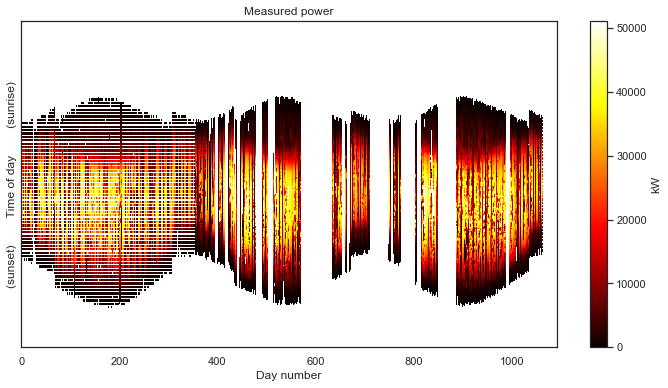

In [13]:
power_matrix_raw = make_2d(df, key='dc_power', zero_nighttime=False, interp_missing=False)
plot_2d(power_matrix_raw);

That is definitely not as clean as the previous data set. For starters, we can see that we are completely missing nighttime data. Also, the first year of data has a lot of holes; this is due to the first year being aggregated at lower frequency (every 15 minutes) than the subsequent two years (every 5 minutes). There large gaps in data throughout the second two years. Also, we can see that there are shifts each year due to daylight savings time. This one has it all!

The first thing we'll do is fill in nighttime data with zero values. The `make_2d` function has a keyword arguement `zero_nighttime` which we set to `True`. This will have the function attempt to detect missing values associated with the nighttime, and fill them with zeros, as seen below.

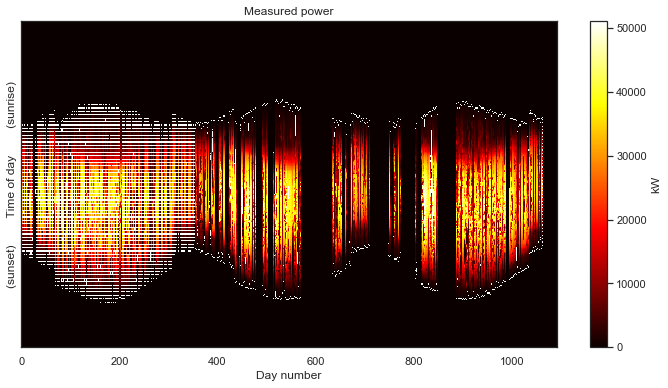

In [14]:
power_matrix_night = make_2d(df, key='dc_power', zero_nighttime=True, interp_missing=False)
plot_2d(power_matrix_night);

Notebly, this method does not fill in the missing values associated with the low data rate in the first year. It does, however, fill in the large, multiday gaps in the second and third years, which is fine. We have no idea what happened on those days anyway. 

Now let's deal with the missing data in the first year. The keyword arguement `interp_missing` will fill the remaining gaps in the data using a linear interpolation. 

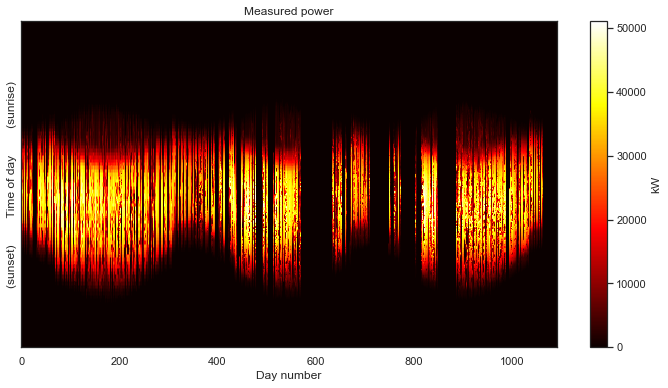

In [15]:
power_matrix_fill = make_2d(df, key='dc_power', zero_nighttime=True, interp_missing=True)
plot_2d(power_matrix_fill);

There are no longer any gaps in the data! We also see that the sunrise and sunset times have been cleaned up, removing that "white boarder" around the non-zero data.

Finally, we use the function `fix_time_shifts` from `solardatatools` to automatically detect the points in the data set where a time shift has occured and remove the shifts. This approach is based on some fancy math that is the subject of an upcoming paper. The algorithm can be run on any data set, and it will correctly do nothing if no shifts are detected.

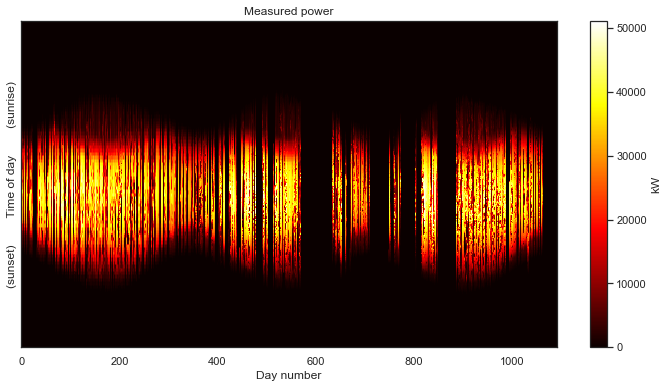

In [16]:
power_matrix_clean = fix_time_shifts(power_matrix_fill)
plot_2d(power_matrix_clean);

There we have it! While not still not as clean as the first data set we looked at, we can make make out a distinct 3-year PV power signal. Despite the remaining corruption, we can see a clear periodicity on a yearly cycle. The system is experiencing morning shade in the summer and most likely some evening shade in the winter.

## Analysis example: fitting a clear sky baseline

Last year, I [wrote a paper](https://www.researchgate.net/publication/332929283_Statistical_Clear_Sky_Fitting_Algorithm) on using [Generalized Low Rank Models](https://web.stanford.edu/~boyd/papers/glrm.html) (GLRM) to fit a clear sky baseline to PV power data. This provides an estimation of the power output of the system under clear sky conditions for any day in the data set. The method requires no physical model of the site or system, [unique for clear sky models](https://www.e-education.psu.edu/eme810/node/544). The difference is that this is a _descriptive_ (or data-driven) model rather than a _predictive_ model.

This model is useful for a number of reasons. It is a baseline of system behavior, so deviations from that baseline can typically be thought of as the impact of clouds and the weather on system power output. Soiling signals are also visible as deviations from this baseline. The baseline is also useful for training statistical forecasting models. The baseline additionally provides an estimate of the long-term, year-over-year degradation rate of the system, a task that typically requires a predictive model and on-site irradiance and weather data.

As we will see below, we are able to fit this statistical clear sky model to our freshly cleaned data set. This algorithm requires the data to be in a clean 2-D array form. So, the 2-D formulation of the data is useful for both viewing the data and for model fitting. In fact, that visually noticable yearly periodicity and seasonal structure is exactly what the GLRM picks up on in the data.

With that, let's fit the clear sky model. First some imports from `StatiscialClearSky`: https://github.com/slacgismo/StatisticalClearSky. This code is also available on PyPI and Conda.

In [17]:
import sys
sys.path.append(home + '/Documents/ClearSky/StatisticalClearSky/')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType

Next we set up the fitting object. It is instantiated with the cleaned power matix, along with keyword arguements defining the rank of the low-rank model and the convex solver to use to solve the underlying mathematical problems in the algorithm. Information on Mosek is avaible here: https://www.mosek.com/

In [18]:
clear_sky_fit = IterativeFitting(power_matrix_clean, rank_k=6, solver_type=SolverType.mosek)

Next we execute the algorithm. This fits the clear sky model to the data. It is an iterative algorithm, based on solving a series of convex optimization problems, as detailed in the 2018 paper. An upcoming paper will detail the sensitivity and setting recommendations for the tuning parameters `mu_l`, `mu_r`, and `tau`.

In [19]:
clear_sky_fit.execute(mu_l=1e4, mu_r=5e3, tau=0.9, max_iteration=10)

obtaining initial value of component r0
obtaining weights
starting at 42550261280.188 [8075174.351660941, 3084.2335460164554, 34297341707.522377, 8244841314.080191]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 11773842.904 [9.01625132e+06 2.47532200e+03 2.75511614e+06 1.26000000e-01]
Caution: residuals increased
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 9655058.417 [6.64297435e+06 1.99171110e+04 2.99216649e+06 4.66000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 9489574.262 [6.36530977e+06 1.84331350e+04 3.10583060e+06 7.63000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 9353330.910 [6.09114404e+06 1.92288640e+04 3.24295778e+06 2.24000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 9283065.924 [6.01976252e+06 1.90892010e+04 3.24421419e+06 9.00000000e-03]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 9174196.417 [5.94212274e+06 1.95049600e+04 3.212568

And now we can view the model that we fit to the data.

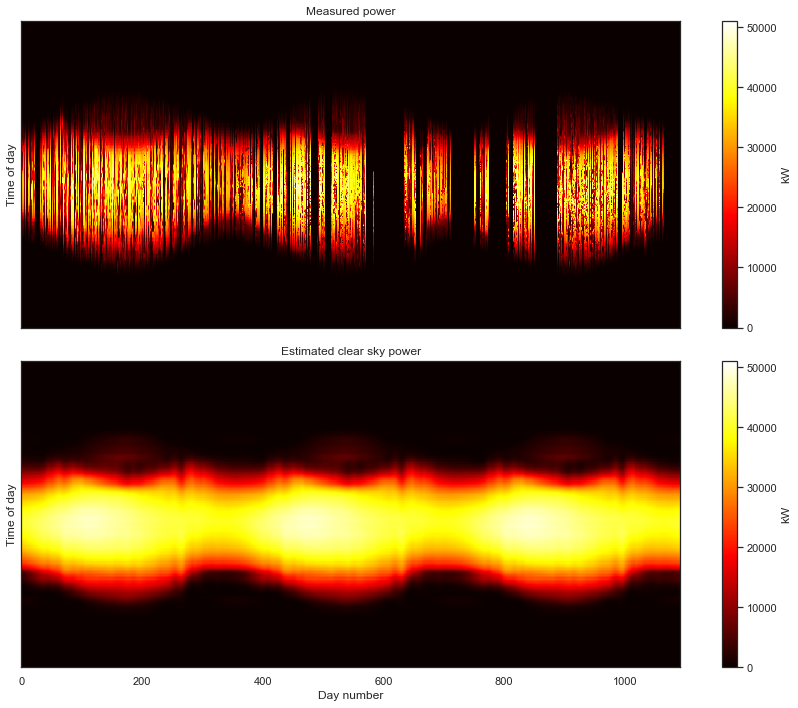

In [20]:
clear_sky_fit.plot_measured_clear();

We can convert both the measured data and the clear sky estimate to daily energy by integrating over eachy day. Below, the daily energy as measured by the data acquisition system is shown in blue. Days that were selected as "mostly clear" by the algorithm are highlighted with orange dots. The orange line is the clear sky daily energy as estimated by the algorithm. Note how the orange line approximates a smoothing envelope fit of the orange dots.

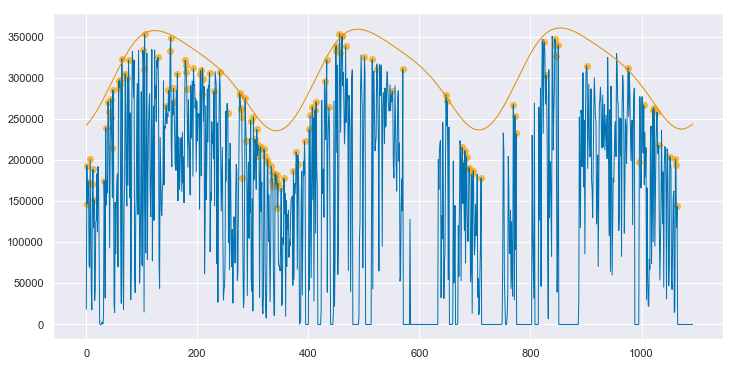

In [21]:
clear_sky_fit.plot_energy(show_clear=True);

If you compare this fit to that for the clean data, as shown in Appendix A, you can see that this fit is not quite as
good. However, the results are impressive given the poor state of the underlying data. By applying the data cleaning steps described above, the algorithm is able to pick up on enough of a signal to make a reasonable assesment of this system's baseline performance. As shown in Appendix B, if interpolation is not employed to fill in the data in the first year, the algorithm produces strange, unpredictable results.

We can convert from the 2-D view back to slices of 1-D views. When we do so, we see that the fitted clear sky model accurately tracks the behavior of the system under clear conditions, and interpolates through the cloudy periods.

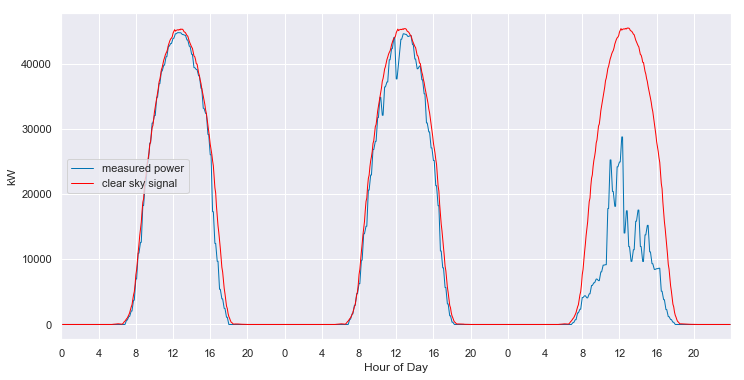

In [22]:
clear_sky_fit.ts_plot(start_day=60, num_days=3, figsize=(12,6), loc=0);

The model even does a reasonable job of following the behavior of the system when it is experiencing morning shade, as shown below.

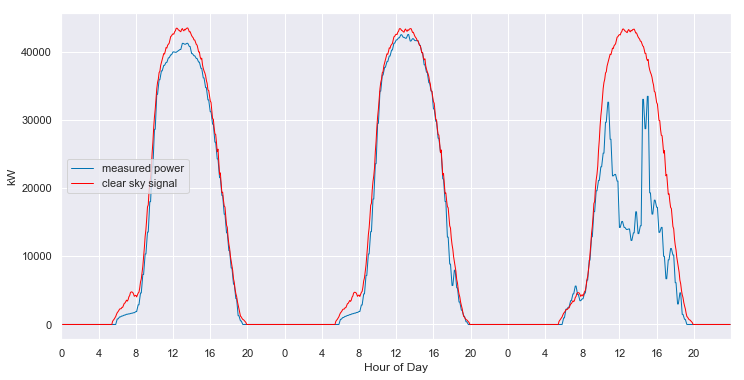

In [23]:
clear_sky_fit.ts_plot(start_day=205, num_days=3, figsize=(12,6), loc=0);

This behavior is consistent throughout the various seasons and the years.

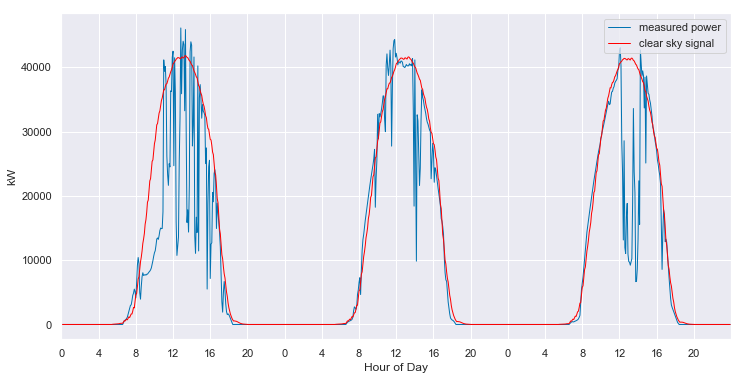

In [24]:
clear_sky_fit.ts_plot(start_day=1000, num_days=3, figsize=(12,6), loc=0);

And, the model even provides estimates of the what the clear sky power output of the system should have been, in the periods that are completely missing data.

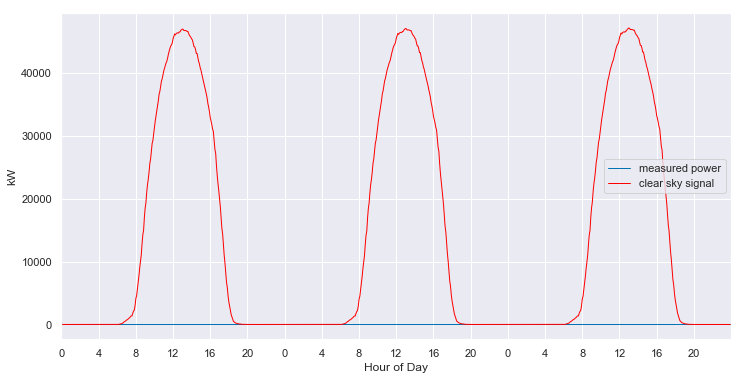

In [25]:
    clear_sky_fit.ts_plot(start_day=800, num_days=3, figsize=(12,6), loc=0);

The estimated year-over-year degredation rate is returned as a byproduct of model fitting (in this case, basically no evidence of degredation).

In [26]:
msg = 'The system degradation rate is {:.2f}%'
print(msg.format(clear_sky_fit.degradation_rate().item() * 100))

The system degradation rate is 0.44%


### Conclusion

We've seen that the quality of PV power data sets that exist in the real world can very drastically in quality. In the case of highly corrupted data sets, we can still extract useful information from the data by careful cleaning of the data and by using algorithms designed to be robust to missing and bad data. In fact, it is only by careful cleaning and using all available data that we are able to fit a reasonable clear sky model to such a corrupted data set.

### Acknowledgements 

This material is based upon work supported by the U.S. Department of Energy’s Office of Energy Efficiency and Renewable Energy (EERE) under Solar Energy Technologies Office (SETO) Agreement Number 34911.

### Appendix A: statistical clear sky fitting on good data

In [27]:
clear_sky_fit1 = IterativeFitting(make_2d(df1, key='dc_power', zero_nighttime=True, interp_missing=True),
                                  rank_k=6, solver_type=SolverType.mosek)
clear_sky_fit1.execute(mu_l=1e4, mu_r=5e3, tau=0.9, max_iteration=10)

obtaining initial value of component r0
obtaining weights
starting at 33906265296.765 [17890865.258460227, 10426.906285362822, 25677460152.677307, 8210903851.923152]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 20978127.870 [1.38371398e+07 6.36089000e+03 7.13462711e+06 2.30000000e-02]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 18075047.501 [1.11465912e+07 1.68806870e+04 6.91157524e+06 3.40000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 17799930.145 [1.09342371e+07 1.58753850e+04 6.84981736e+06 2.94000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 17701226.915 [1.08924324e+07 1.65226920e+04 6.79227161e+06 1.63000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 17641001.886 [1.08814259e+07 1.60914000e+04 6.74348448e+06 1.26000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 17594734.468 [1.08748918e+07 1.58956380e+04 6.70394679e+06 1.92000000e-01]


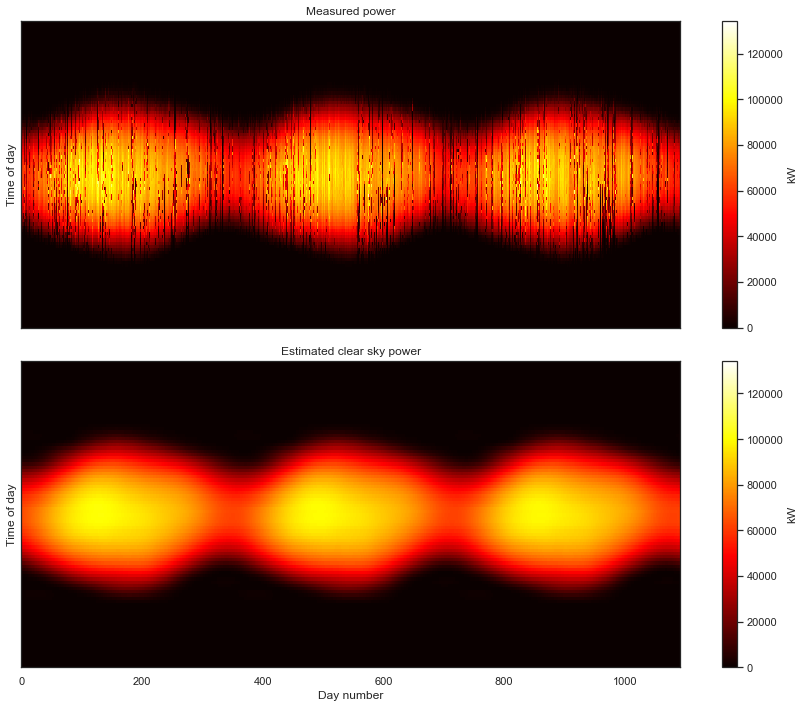

In [28]:
clear_sky_fit1.plot_measured_clear();

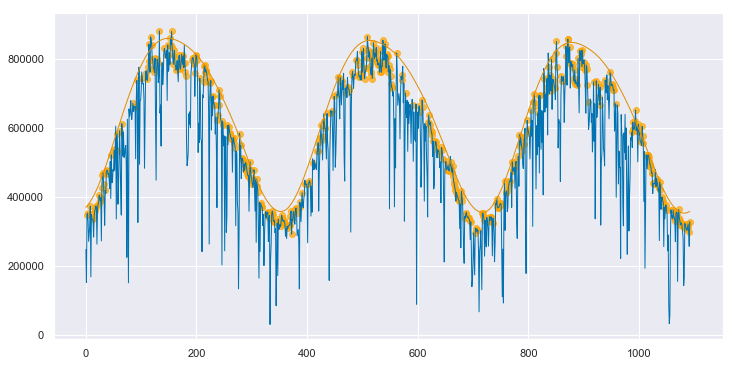

In [29]:
clear_sky_fit1.plot_energy(show_clear=True);

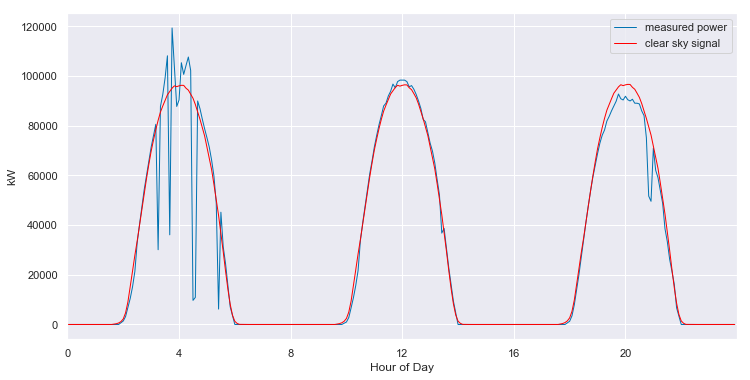

In [30]:
clear_sky_fit1.ts_plot(start_day=455, num_days=3, figsize=(12,6), loc=0);

In [31]:
msg = 'The system degradation rate is {:.2f}%'
print(msg.format(clear_sky_fit1.degradation_rate().item() * 100))

The system degradation rate is -0.69%


### Appendix B: lazy missing data filling

Instead of linearly interpolating the daytime values in the first year, what if we had just filled with zeros everywhere?

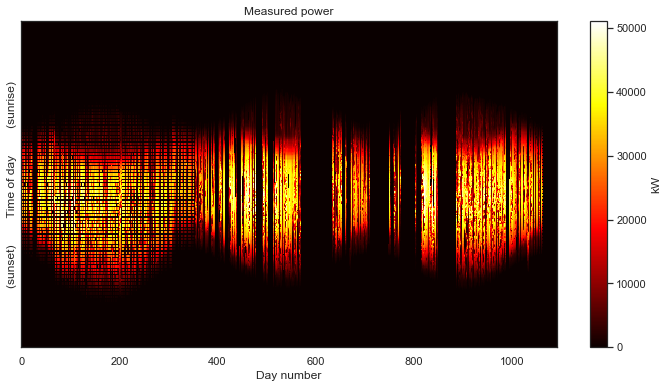

In [32]:
nan_mask = np.isnan(power_matrix_raw)
power_matrix_lazy = np.copy(power_matrix_raw)
power_matrix_lazy[nan_mask] = 0
power_matrix_lazy = fix_time_shifts(power_matrix_lazy)
plot_2d(power_matrix_lazy);

That's not looking good. It appears that filling with zeros has caused the time shift fixing algorithm to go haywire. But just for kicks, let's see what the statistical clear sky fitting algorithm does with the data.

In [33]:
clear_sky_fit2 = IterativeFitting(power_matrix_lazy, rank_k=6, solver_type=SolverType.mosek)
clear_sky_fit2.execute(mu_l=1e4, mu_r=5e3, tau=0.9, max_iteration=10)

obtaining initial value of component r0
obtaining weights
starting at 44859059363.791 [16796941.217175152, 33123.42415658021, 31713130948.786602, 13129098350.363462]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 13499598.807 [1.04095943e+07 4.32879300e+03 3.08567556e+06 1.41000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 11469523.238 [8.26640430e+06 2.12687760e+04 3.18184961e+06 5.52000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 11282367.487 [7.99225285e+06 2.01813390e+04 3.26993317e+06 1.30000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 11161732.114 [7.78115696e+06 1.95071600e+04 3.36106790e+06 9.20000000e-02]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 11099364.419 [7.69177366e+06 2.01095080e+04 3.38748090e+06 3.43000000e-01]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 11053418.574 [7.62482854e+06 2.04653940e+04 3.40812429e+06 3.56000000e-01]


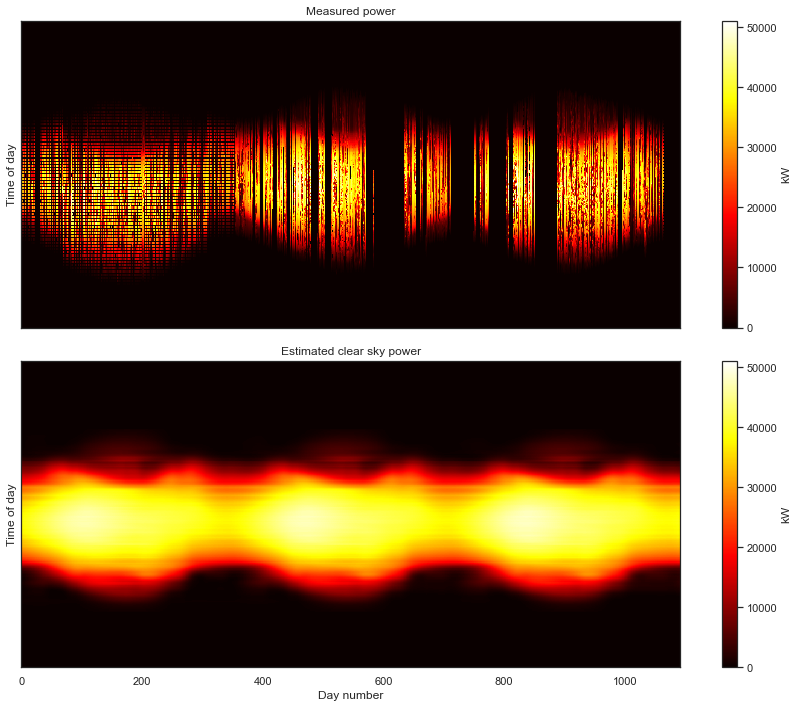

In [34]:
clear_sky_fit2.plot_measured_clear();

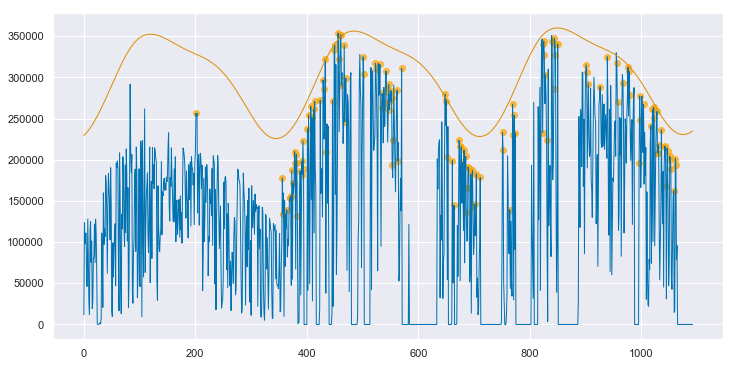

In [35]:
clear_sky_fit2.plot_energy(show_clear=True);

We can see that the algorithm has basically ingored the first year. It selected only one day to include in the fit in the first year (orange dot), but then it treats that day as an outlier and does not utilize to understand the shape of the clear sky signal. Note that you can see the effects of the incorrect attempt at time shift fixing in this plot.

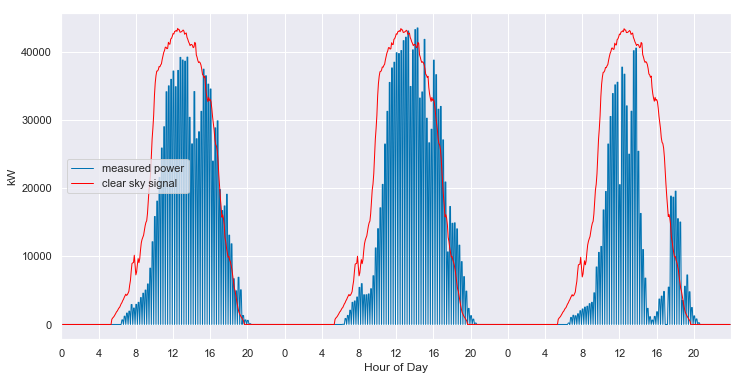

In [36]:
clear_sky_fit2.ts_plot(start_day=190, num_days=3, figsize=(12,6), loc=0);

The algorithm still fits the days in the second and third years quite well.

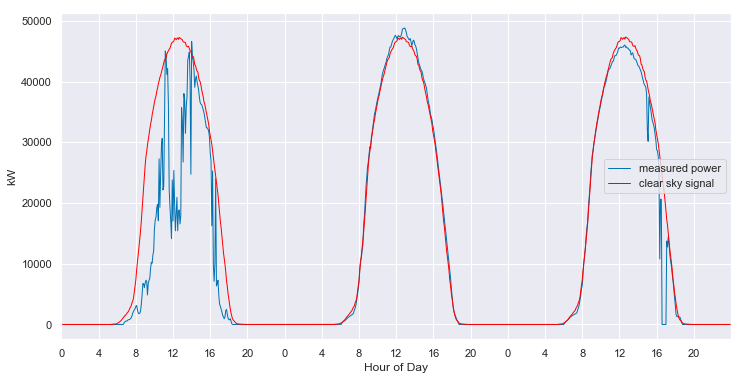

In [37]:
clear_sky_fit2.ts_plot(start_day=455, num_days=3, figsize=(12,6), loc=0);

But now we get an impossible degradation rate. The algorithm thinks that they performance of the system is _improving_ by 1.07% year-over-year.

In [38]:
msg = 'The system degradation rate is {:.2f}%'
print(msg.format(clear_sky_fit2.degradation_rate().item() * 100))

The system degradation rate is 1.07%


Okay, but what if we just ignore the bad year? Maybe we just need to throw that whole year out. Well, that's a pretty bad waste of data, but we might as well try it.

In [39]:
clear_sky_fit3 = IterativeFitting(power_matrix_lazy[:, 365:], rank_k=6, solver_type=SolverType.mosek)
clear_sky_fit3.execute(mu_l=1e4, mu_r=5e3, tau=0.9, max_iteration=10)

obtaining initial value of component r0
obtaining weights
starting at 32549105845.013 [3282668.7987403586, 4812.206270276514, 26873894278.2651, 5671924085.74261]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 142824133.761 [1.42824134e+08 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Caution: residuals increased
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 3836229.382 [3.74738146e+06 3.74454300e+03 8.51033840e+04 0.00000000e+00]
Caution: residuals increased
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 3616954.203 [3.5460548e+06 2.6358250e+03 6.8263578e+04 0.0000000e+00]
Caution: residuals increased
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 3607070.411 [3.53543515e+06 2.72108000e+03 6.89141860e+04 0.00000000e+00]
Caution: residuals increased
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 3603113.893 [3.53088803e+06 2.52674200e+03 6.96991240e+04 0.00000000e+00]
Caution: residuals increased
Mimin

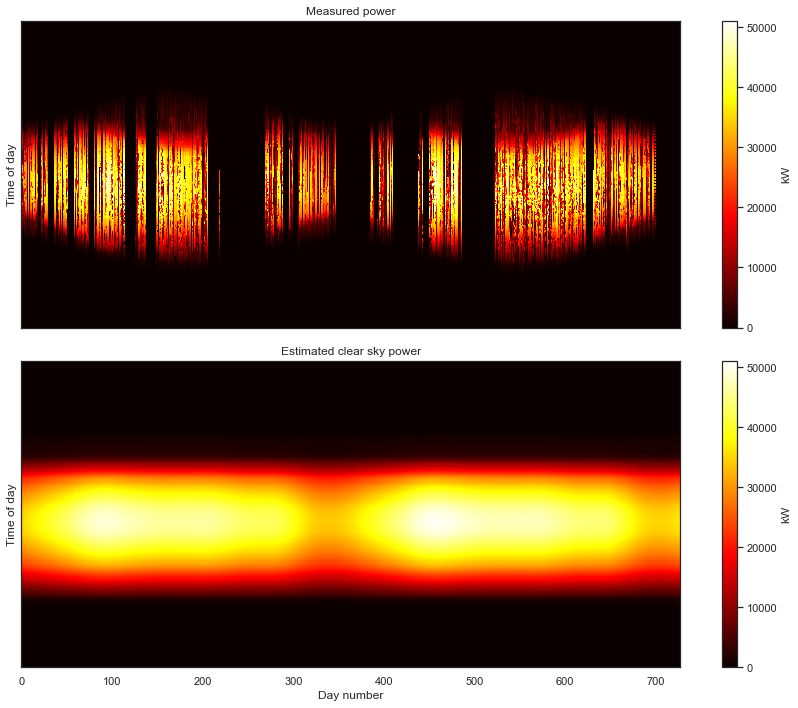

In [40]:
clear_sky_fit3.plot_measured_clear();

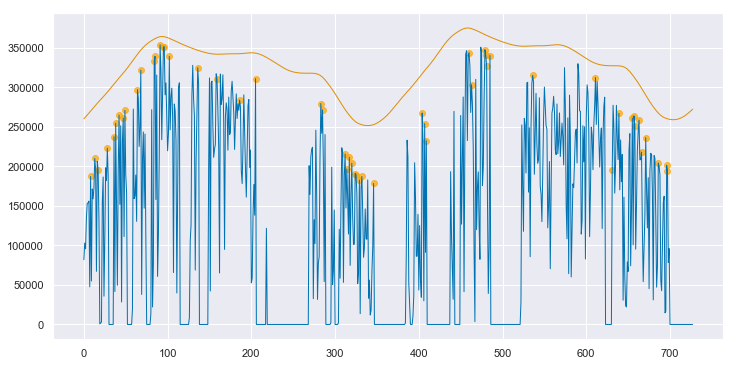

In [41]:
clear_sky_fit3.plot_energy(show_clear=True);

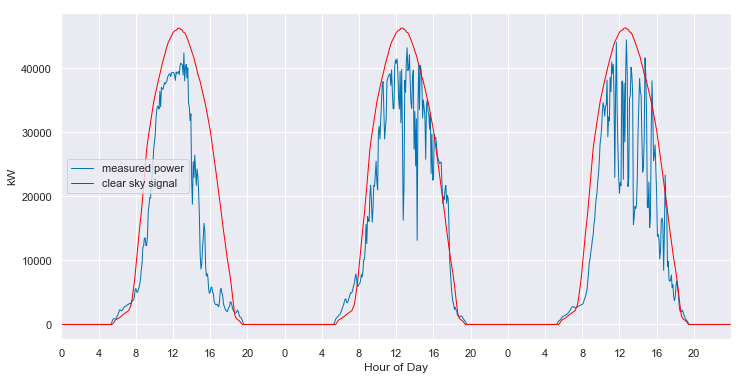

In [42]:
clear_sky_fit3.ts_plot(start_day=190, num_days=3, figsize=(12,6), loc=0);

In [43]:
msg = 'The system degradation rate is {:.2f}%'
print(msg.format(clear_sky_fit2.degradation_rate().item() * 100))

The system degradation rate is 1.07%


The remaining data is too corrupted by the gaps that the algorithm cannot extract a reasonable clear sky baseline signal. Interestingly, we get the same, non-phyiscal degradation rate of +1.07%.